In [ ]:
# For the LSTM model.

C:\Users\24015965\AppData\Local\Temp\ipykernel_13128\450318209.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

--- Starting Data Acquisition and Preprocessing ---
--- Data Preprocessing Complete ---

--- Starting Model Building and Training (Epochs=50) ---
Epoch 1/50



c:\ChilliBanMian\stock_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0025
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.9047e-04
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.4094e-04
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.1387e-04
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.5989e-04
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 4.4180e-04
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 4.2029e-04
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.6034e-04
Epoch 9/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.3883e-04
Epoch 10/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.5813e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.2931e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.9625e-04
Epoch 13/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.9928e-04
Epoch 14/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1379e-04
Epoch 15/50
93/93 ━━━━━━━━━━━━

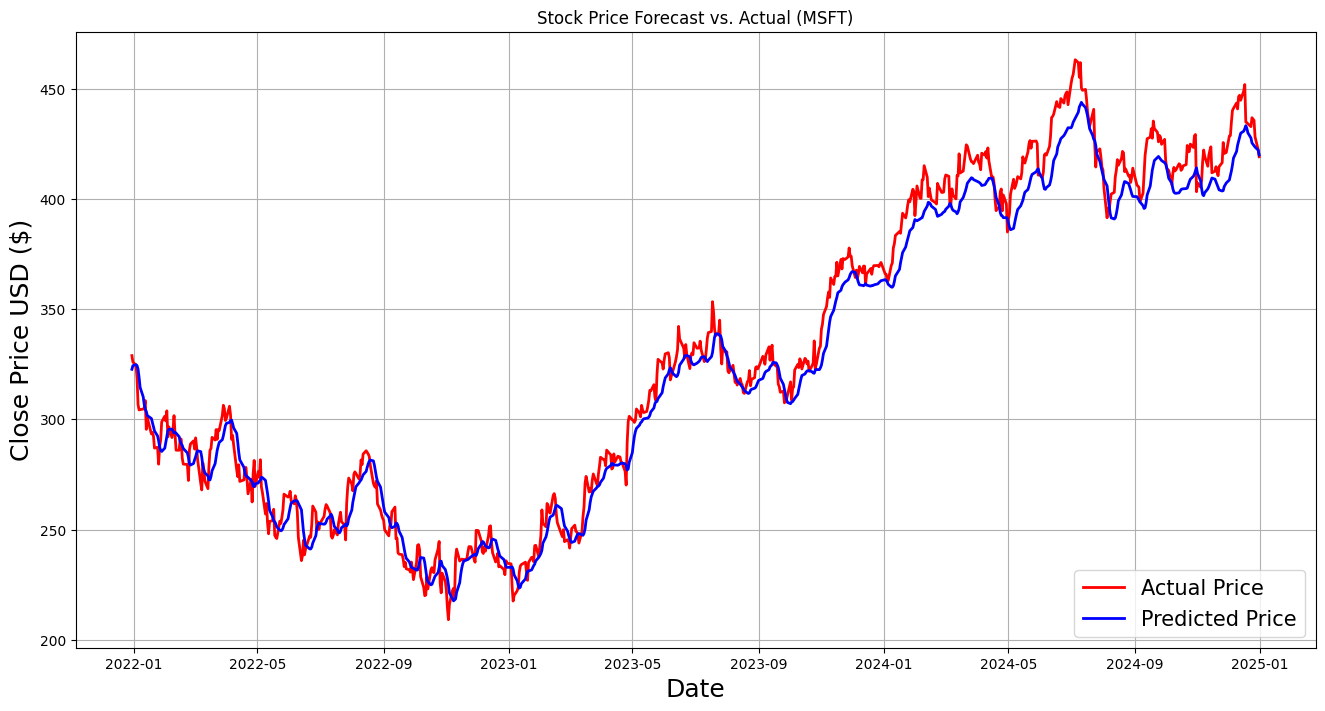

Model saved successfully as lstm_stock_model.h5


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf

# Choose the stock
ticker = 'MSFT'
start_date = '2010-01-01'
end_date = '2025-01-01'
time_step = 60 # Look-back window (60 days)


# Get the data


print("--- Starting Data Acquisition and Preprocessing ---")


stock_data = yf.download(ticker, start=start_date, end=end_date)
stock_data = stock_data.dropna()


data_close = stock_data['Close'].values.reshape(-1, 1)

#Normalization?
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_close)

training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - time_step:, :]


def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("--- Data Preprocessing Complete ---")


#Model Training


print("\n--- Starting Model Building and Training (Epochs=50) ---")

#Model Building
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

#Train
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=1
)

print("--- Training Complete lol ---")

#Evaluation of the model

#predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # Convert back to USD price from normalization 0-1


actual_prices = data_close[training_data_len:]

#Second Evaluation??????
rmse = math.sqrt(mean_squared_error(actual_prices, predictions))
print(f"\n--- Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")

# Visualization
test_dates = stock_data.index[training_data_len:].values

plt.figure(figsize=(16, 8))
plt.title(f'Stock Price Forecast vs. Actual ({ticker})')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

plt.plot(test_dates, actual_prices, color='red', linewidth=2, label='Actual Price')
plt.plot(test_dates, predictions, color='blue', linewidth=2, label='Predicted Price')

plt.legend(loc='lower right', fontsize=15)
plt.grid(True)
plt.show()



# Import stuff
from tensorflow.keras.models import save_model  #slight issue but shouldnt affect model

# file
model.save('lstm_stock_model.h5')

print("Model saved successfully as lstm_stock_model.h5,eta to print graph (5mins?)")

In [ ]:
# C:/ChilliBanMian/stock_env/Scripts/streamlit.exe run c:/ChilliBanMian/app.py